# GHG emissions of global countries in a given year (in a treemap)

In [1]:
import os
import sys

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../"))


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify
import numpy as np

from data_analysis.edgar_geo import *
from data_analysis.illustrator_strings import *
from data_analysis.texts_emissions import *
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_code
from data_analysis.eurostat_population_utils import get_eurostat_population_data

## Parameters

In [3]:
YEAR = 2022

# Don't convert svg texts to curves.
plt.rcParams['svg.fonttype'] = 'none'

## Fetch the data from EDGAR

In [4]:
edgar_ghg_path = '../../data/edgar/v8.0/EDGAR_AR5_GHG_1970_2022.xlsx'

edgar_cols = {
    'C_group_IM24_sh': 'geo',
    'Country_code_A3': 'code',
    'Name': 'country',
    'Y_2022': 'emissions'
}

edgar = pd.read_excel(edgar_ghg_path, sheet_name='TOTALS BY COUNTRY', header=9)
edgar = edgar[list(edgar_cols)].rename(columns=edgar_cols)

# Do not exclude international shipping and aviation
# edgar = edgar[~edgar['code'].isin(['SEA', 'AIR'])]

In [9]:
edgar.head()

,geo,code,country,emissions
0,Rest Central America,ABW,Aruba,496.682755
1,India +,AFG,Afghanistan,29117.879023
2,Southern_Africa,AGO,Angola,66480.057594
3,Rest Central America,AIA,Anguilla,28.098791
4,Int. Aviation,AIR,Int. Aviation,425963.735187


In [10]:
edgar['geo'].unique()

array(['Rest Central America', 'India +', 'Southern_Africa',
       'Int. Aviation', 'Central Europe', 'Middle_East',
       'Rest South America', 'Russia +', 'Oceania', 'OECD_Europe',
       'Eastern_Africa', 'Western_Africa', 'Ukraine +', 'Brazil',
       'Southeastern Asia', 'Canada', 'China +', 'Northern_Africa',
       'Indonesia +', 'Japan', 'Asia-Stan', 'Korea', 'Mexico',
       'Int. Shipping', 'USA', 'Turkey'], dtype=object)

## Import global population data from UN

In [11]:
un_population_path = '../../data/un/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx'
un_cols = {
    'ISO3 Alpha-code': 'code',
    'Year': 'year',
    'Total Population, as of 1 July (thousands)': 'population'
}

un_pop = pd.read_excel(un_population_path, sheet_name='Estimates', header=16)
un_pop = un_pop[list(un_cols)].rename(columns=un_cols)
un_pop.head()

,code,year,population
0,NaN,1950.0,2499322.157
1,NaN,1951.0,2543130.38
2,NaN,1952.0,2590270.899
3,NaN,1953.0,2640278.797
4,NaN,1954.0,2691979.339


In [12]:
un_pop = un_pop.dropna().loc[un_pop['year'] == 2021]
un_pop['population'] = un_pop['population'].apply(lambda x: x*1000)
un_pop = un_pop.drop('year', axis=1)
un_pop.head()

,code,population
1803,BDI,12551213.0
1875,COM,821625.0
1947,DJI,1105557.0
2019,ERI,3620312.0
2091,ETH,120283026.0


## Merge data from UN and EDGAR to get population-based emission stats

In [13]:
emissions = pd.merge(edgar, un_pop, on='code')
emissions

,geo,code,country,emissions,population
0,Rest Central America,ABW,Aruba,496.682755,106537.0
1,India +,AFG,Afghanistan,29117.879023,40099462.0
2,Southern_Africa,AGO,Angola,66480.057594,34503774.0
3,Rest Central America,AIA,Anguilla,28.098791,15753.0
4,Central Europe,ALB,Albania,7983.378894,2854710.0
...,...,...,...,...,...
214,Oceania,WSM,Samoa,548.424096,218764.0
215,Middle_East,YEM,Yemen,38006.043126,32981641.0
216,Southern_Africa,ZAF,South Africa,534531.651545,59392255.0
217,Southern_Africa,ZMB,Zambia,30330.585040,19473125.0


Group countries in their geographical regions

In [17]:
geo_map = {
    'Africa': ['Southern_Africa', 'Eastern_Africa', 'Western_Africa', 'Northern_Africa'],
    'Europe': ['Central Europe', 'OECD_Europe', 'Ukraine +'],
    'Russia': ['Russia +'],
    'Asia': ['India +', 'Middle_East', 'Southeastern Asia', 'China +', 'Indonesia +', 'Japan', 'Asia-Stan', 'Korea', 'Turkey'],
    'NAmerica': ['Canada', 'USA', 'Mexico'],
    'SCAmerica': ['Rest Central America', 'Rest South America', 'Brazil'],
    'Oceania': ['Oceania']
}

geo_map_flat = {y: x for x in geo_map for y in geo_map[x]}

eu_sum = emissions.loc[emissions['geo'].isin(geo_map['Europe'])].sum()
africa_sum = emissions.loc[emissions['geo'].isin(geo_map['Africa'])].sum()
asia_sum = emissions.loc[emissions['geo'].isin(geo_map['Asia'])].sum()
na_sum = emissions.loc[emissions['geo'].isin(geo_map['NAmerica'])].sum()
sca_sum = emissions.loc[emissions['geo'].isin(geo_map['SCAmerica'])].sum()
oce_sum = emissions.loc[emissions['geo'].isin(geo_map['Oceania'])].sum()

emissions['geo_group'] = emissions['geo'].map(geo_map_flat)
emissions

,geo,code,country,emissions,population,geo_group
0,Rest Central America,ABW,Aruba,496.682755,106537.0,SCAmerica
1,India +,AFG,Afghanistan,29117.879023,40099462.0,Asia
2,Southern_Africa,AGO,Angola,66480.057594,34503774.0,Africa
3,Rest Central America,AIA,Anguilla,28.098791,15753.0,SCAmerica
4,Central Europe,ALB,Albania,7983.378894,2854710.0,Europe
...,...,...,...,...,...,...
214,Oceania,WSM,Samoa,548.424096,218764.0,Oceania
215,Middle_East,YEM,Yemen,38006.043126,32981641.0,Asia
216,Southern_Africa,ZAF,South Africa,534531.651545,59392255.0,Africa
217,Southern_Africa,ZMB,Zambia,30330.585040,19473125.0,Africa


Aggregate geographical groups 

In [19]:
def create_geo_aggregations(df, arr):
    # name, include_geo_groups, include_codes, exclude_codes
    geo_group_emissions = []
    for item in arr:
        geo_group_emissions.append([
            item['name'],
            df.loc[df['geo_group'].isin(item['include_geo_groups'])]['emissions'].sum()
            + df.loc[df['code'].isin(item['include_codes'])]['emissions'].sum()
            - df.loc[df['code'].isin(item['exclude_codes'])]['emissions'].sum(),
            df.loc[emissions['geo_group'].isin(item['include_geo_groups'])]['population'].sum()
            + df.loc[df['code'].isin(item['include_codes'])]['population'].sum()
            - df.loc[df['code'].isin(item['exclude_codes'])]['population'].sum()
        ])
    columns = ['id', 'emissions', 'population']
    geo_group_emissions_df = pd.DataFrame(geo_group_emissions, columns=columns)
    return geo_group_emissions_df

geo_topology = [
    {'name': 'Europe', 'include_geo_groups': ['Europe'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'Russia', 'include_geo_groups': ['Russia'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'Asia', 'include_geo_groups': ['Asia'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'Africa', 'include_geo_groups': ['Africa'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'NAmerica', 'include_geo_groups': ['NAmerica'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'SCAmerica', 'include_geo_groups': ['SCAmerica'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'Oceania', 'include_geo_groups': ['Oceania'], 'include_codes': [], 'exclude_codes': [], 'subset_of': ''},
    {'name': 'Europe w/o Russia, EU', 'include_geo_groups': ['Europe'], 'include_codes': [], 'exclude_codes': [e.value for e in EU], 'subset_of': 'Europe'},
    {'name': 'EU', 'include_geo_groups': [], 'include_codes': [e.value for e in EU], 'exclude_codes': [], 'subset_of': 'Europe'},
    {'name': 'Asia w/o China, India', 'include_geo_groups': ['Asia'], 'include_codes': [], 'exclude_codes': ['CHN', 'IND'], 'subset_of': 'Asia'},
    {'name': 'China', 'include_geo_groups': [], 'include_codes': ['CHN'], 'exclude_codes': [], 'subset_of': 'Asia'},
    {'name': 'India', 'include_geo_groups': [], 'include_codes': ['IND'], 'exclude_codes': [], 'subset_of': 'Asia'},
    {'name': 'USA', 'include_geo_groups': [], 'include_codes': ['USA'], 'exclude_codes': [], 'subset_of': 'NAmerica'},
    {'name': 'NAmerica w/o USA', 'include_geo_groups': ['NAmerica'], 'include_codes': [], 'exclude_codes': ['USA'], 'subset_of': 'NAmerica'}
]

geo_group_emissions = create_geo_aggregations(
    emissions,
    geo_topology
)
geo_group_emissions

,id,emissions,population
0,Europe,4.505865e+06,5.913388e+08
1,Russia,2.676098e+06,1.619647e+08
2,Asia,3.080705e+07,4.681286e+09
3,Africa,3.413584e+06,1.382928e+09
4,NAmerica,7.594170e+06,5.018637e+08
5,SCAmerica,2.873712e+06,5.291532e+08
6,Oceania,6.676793e+05,3.454229e+07
7,"Europe w/o Russia, EU",9.174318e+05,1.462877e+08
8,EU,3.588433e+06,4.450512e+08
9,"Asia w/o China, India",1.117916e+07,1.847829e+09


Run calculations for per-capita and percentage ghg emissions

In [20]:
total_emissions=geo_group_emissions['emissions'].sum()
geo_group_emissions['em_per_capita'] = (geo_group_emissions['emissions'] * 1000000) / geo_group_emissions['population']
geo_group_emissions['em_per_cent'] = (geo_group_emissions['emissions'] * 100) / total_emissions
geo_group_emissions['emissions_summary'] = \
    geo_group_emissions['emissions'].apply(czech_float) + \
    " (" + geo_group_emissions['em_per_cent'].apply(czech_float) + "%)"
geo_group_emissions.sort_values('emissions', ascending=False, inplace=True)
geo_group_emissions

,id,emissions,population,em_per_capita,em_per_cent,emissions_summary
2,Asia,3.080705e+07,4.681286e+09,6580.894156,32.277197,"30 807 048,2 (32,3%)"
10,China,1.568463e+07,1.425893e+09,10999.858790,16.433116,"15 684 626,8 (16,4%)"
9,"Asia w/o China, India",1.117916e+07,1.847829e+09,6049.887854,11.712639,"11 179 156,8 (11,7%)"
4,NAmerica,7.594170e+06,5.018637e+08,15131.938678,7.956573,"7 594 170,1 (8,0%)"
12,USA,6.017443e+06,3.369976e+08,17856.039790,6.304602,"6 017 443,0 (6,3%)"
0,Europe,4.505865e+06,5.913388e+08,7619.768457,4.720890,"4 505 865,1 (4,7%)"
11,India,3.943265e+06,1.407564e+09,2801.481874,4.131442,"3 943 264,6 (4,1%)"
8,EU,3.588433e+06,4.450512e+08,8062.968008,3.759678,"3 588 433,3 (3,8%)"
3,Africa,3.413584e+06,1.382928e+09,2468.374201,3.576485,"3 413 584,2 (3,6%)"
5,SCAmerica,2.873712e+06,5.291532e+08,5430.775008,3.010849,"2 873 712,2 (3,0%)"


## Plot the graphs

In this section, the prepared dataset is used for two subgraphs

### Code for creating the subgraphs

In [21]:
def _draw_treemap_plot(year, df, geo_topology):
    cmap = matplotlib.cm.viridis
    mini = min(df['emissions'])
    maxi = max(df['emissions'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in df['emissions']]
    
    # Make the figure a bit larger to accommodate a complex graph.
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 3.5, 3.5])
        
    def normalize(parent, norm_x, norm_y, norm_dx, norm_dy, ordered_ids):
        curr_level_names = [v['name'] for v in geo_topology if v['subset_of'] == parent]
        curr_level_items = df.loc[df['id'].isin(curr_level_names)]['id'].to_numpy().tolist()
        sizes = df.loc[df['id'].isin(curr_level_items)]['emissions']
        normed = squarify.normalize_sizes(sizes, norm_dx, norm_dy)
        rects = squarify.squarify(normed, norm_x, norm_y, norm_dx, norm_dy)
        ordered_ids += curr_level_items
            
        for new_parent, new_parent_rect in zip(curr_level_items, rects):
            rects += normalize(
                new_parent,
                new_parent_rect["x"],
                new_parent_rect["y"],
                new_parent_rect["dx"],
                new_parent_rect["dy"],
                ordered_ids
            )
        return rects
    
    ordered_ids = []
    rects = normalize('', 0, 0, 100, 100, ordered_ids)
    # Squarify puts the largest square on the bottom left. The resulting graph should have it on
    # the top left, thus flip the y-axis.
    for rect, ordered_id, color in zip(rects, ordered_ids, colors):
        # We are applying some extra padding here on each item manually instead of using the ax.bar edge line drawing.
        # This way, the area between sub-items is colored with the parent's color instead of being overwriten with the edge color.
        # This makes grouping by color clearer. 
        rect["y"] = 100 - rect["y"] - rect["dy"]
        padding = 0.2
        ax.bar(rect["x"] + padding, rect["dy"] - padding,
           width=rect["dx"] - padding, bottom=rect["y"] + padding,
           color=color, label=ordered_id, align="edge")

    # Print the labels of countries and their emission summary
    pad_x = 0.5
    for l, r, c in zip(ordered_ids, rects, colors):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        if l in [v['name'] for v in geo_topology if v['subset_of'] == '']:
            # using < 0.1 instead of == 0 to account for floating point errors
            if r["y"] < 0.1:
                pad_y_text = dy + 1
                pad_y_emissions = dy + 4
                pad_x_text = 0
                pad_x_emissions = 0
            elif r["y"] + r["dy"] > 99.9:
                pad_y_text = - 6
                pad_y_emissions = - 3
                pad_x_text = 0
                pad_x_emissions = 0
            elif r["x"] < 0.1:
                pad_x_text = dx + 1
                pad_x_emissions = dx + 1
                pad_y_text = 1
                pad_y_emissions = 4
            elif r["x"] + r["dx"] > 99.9:
                pad_x_text = - dx - 1
                pad_x_emissions = - dx - 1
                pad_y_text = 1
                pad_y_emissions = 4

            color = c
        else:
            pad_y_text = 1
            pad_y_emissions = 4
            pad_x_text = 0
            pad_x_emissions = 0
            color = "white"
        ax.text(x + pad_x - pad_x_text, y + dy - pad_y_text, l,
                va="top", ha="left", color=color, fontsize=12, fontweight="bold")
        emissions = df.loc[df['id'] == l]['emissions_summary'].item()
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x - pad_x_emissions, y + dy - pad_y_emissions, emissions, va="top",
                ha="left", color=color, fontsize=12)

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    plt.title(
        f"Celkové roční emise států EU za rok {year} v milionech tun CO2 ekv.")
    plt.axis("off")

    plt.savefig("output-Global-treemap.svg")
    plt.show()
    plt.clf()

In [22]:
def _draw_barh_plot(year, df):
    fig = plt.figure(figsize=(5,10))
    df_sorted = df.sort_values(by='em_per_capita', ascending=True)
    plt.barh(df_sorted.index, df_sorted['em_per_capita'], color="lightsteelblue")

    # Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
    fake_bar = plt.barh(df_sorted.index, [0] * df_sorted.index.size)
    # Add emission value labels on the left.        
    plt.bar_label(fake_bar, labels=[czech_float(x) for x in df_sorted['em_per_capita']], padding=-30, fontsize=9)
    # Add country name labels on the right.
    plt.bar_label(fake_bar, labels=df_sorted["country"], padding=3, fontsize=10)

    plt.title(f'Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU za rok {year}.')
    plt.axis("off")

    plt.savefig("output-EU-bars.svg")

### Plot the graphs and export them as SVG

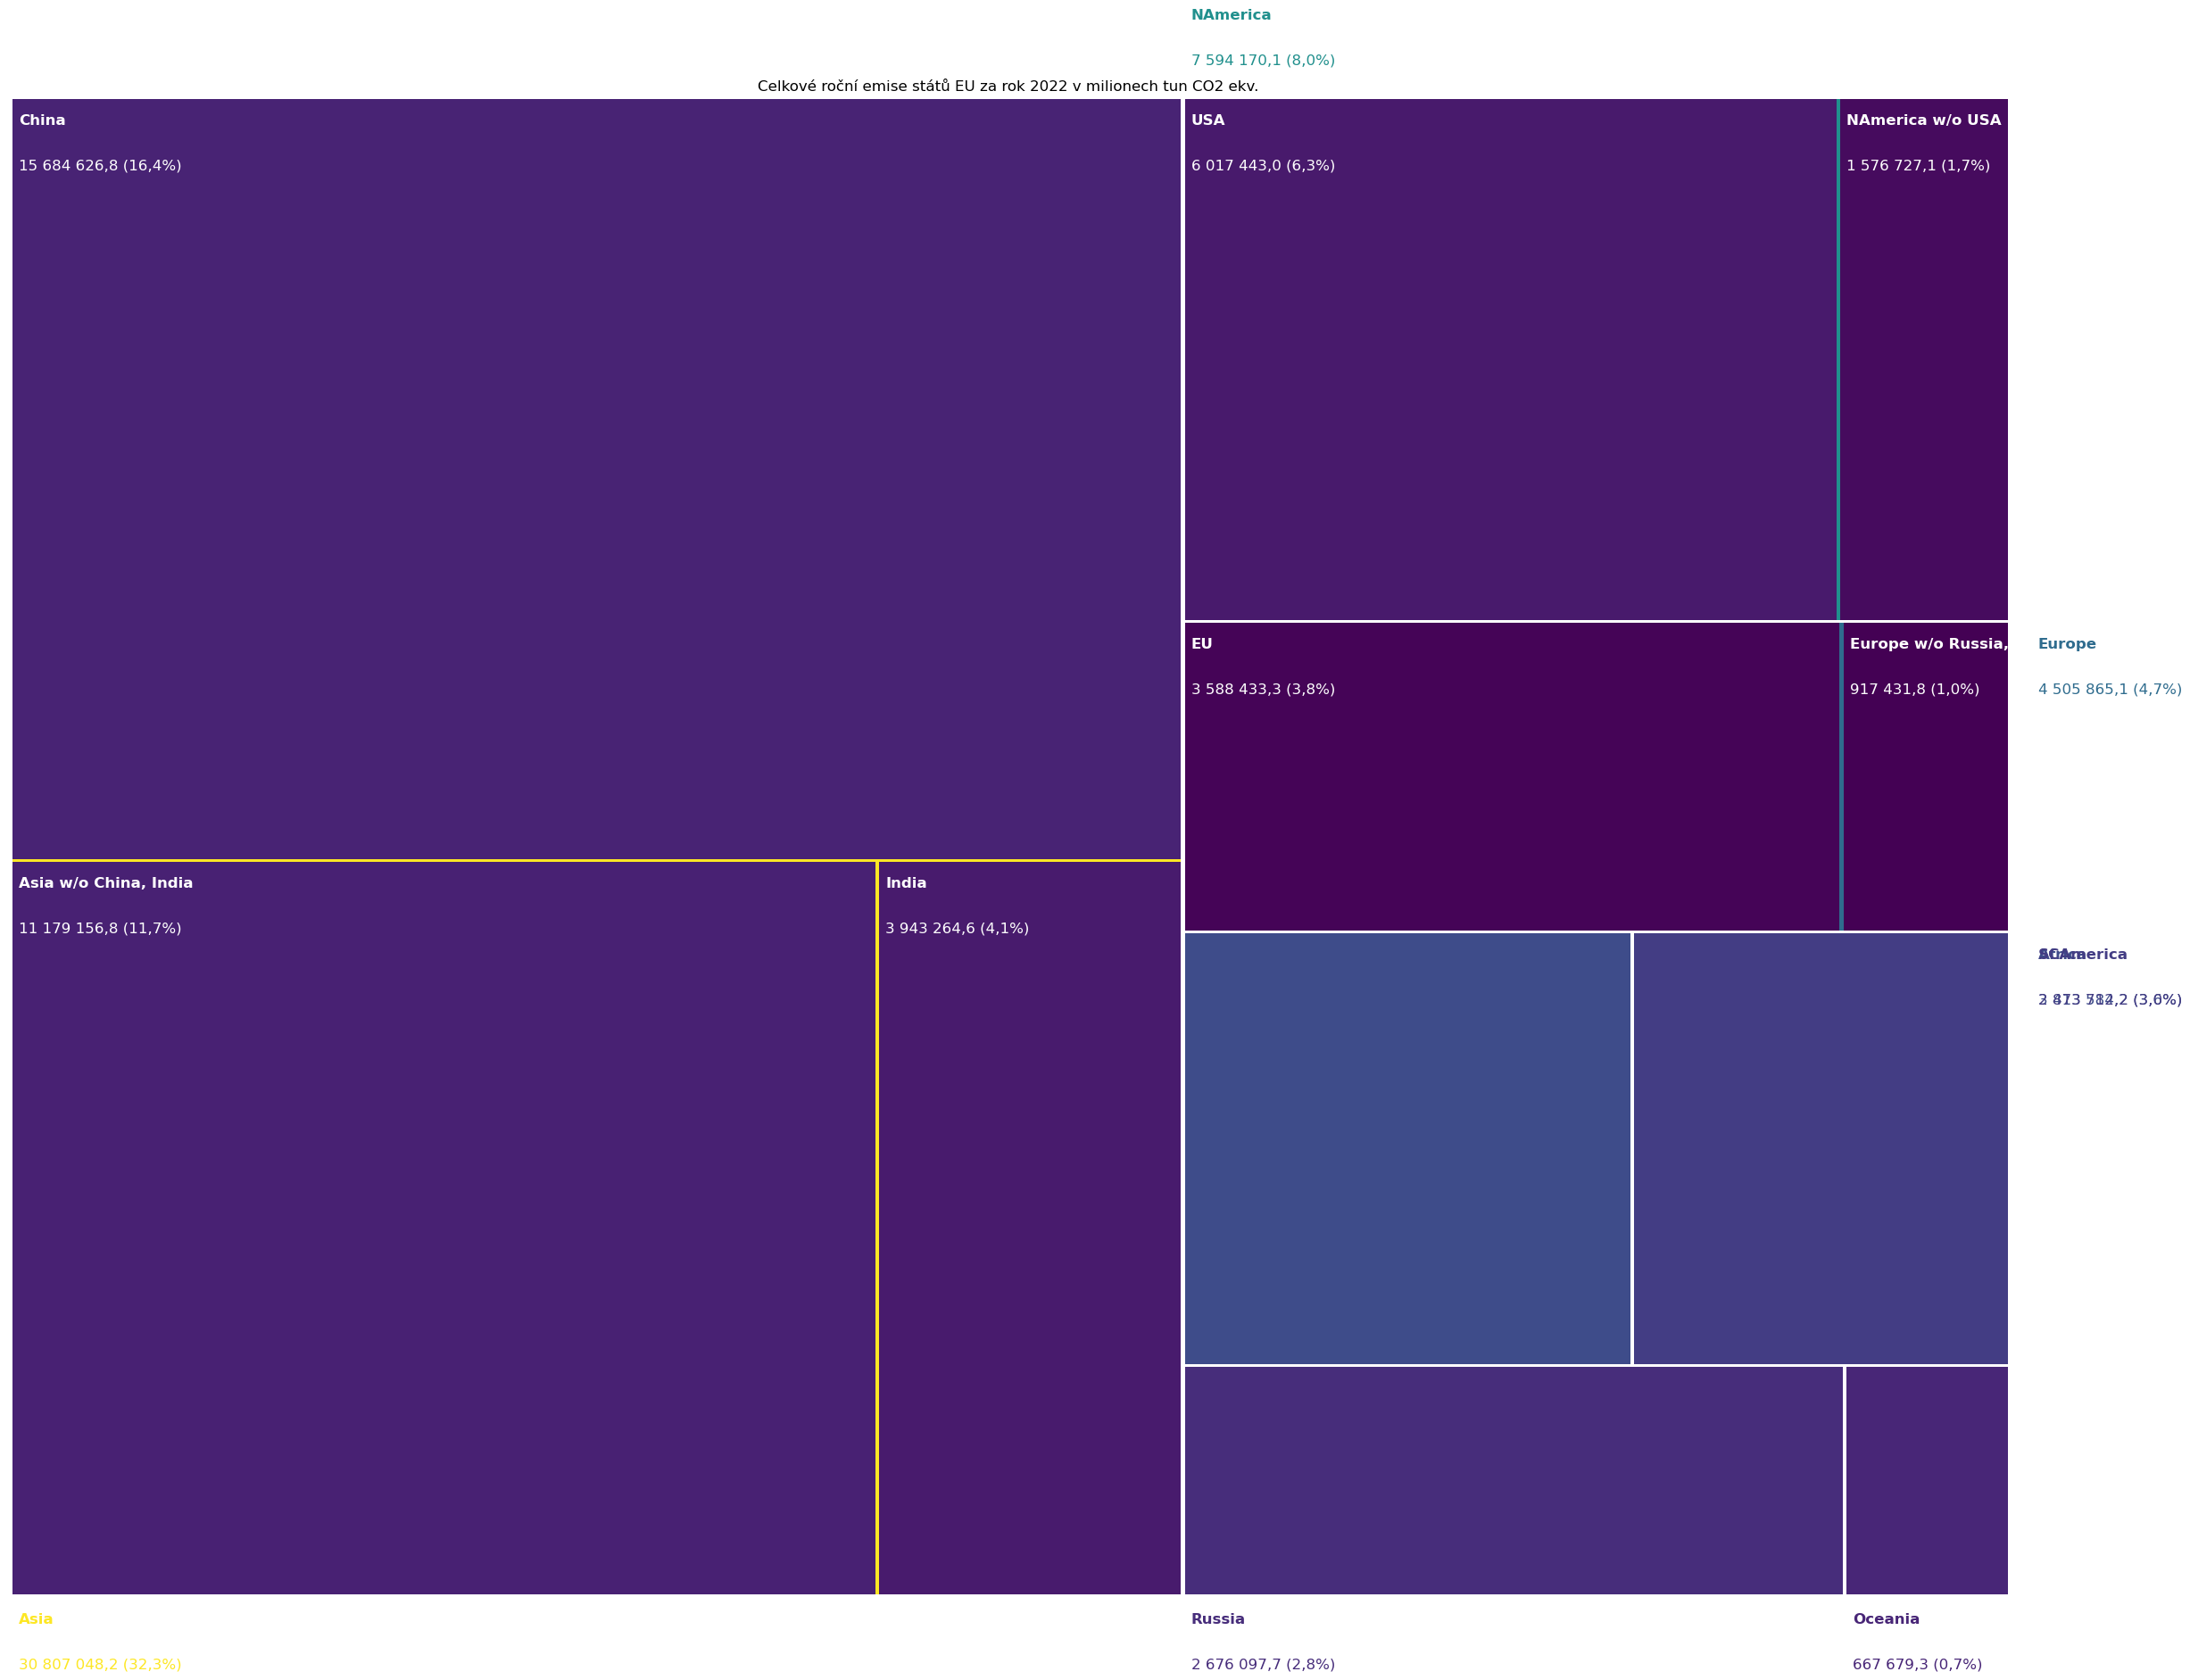

<Figure size 640x480 with 0 Axes>

In [23]:
# draw plots
_draw_treemap_plot(2022, geo_group_emissions, geo_topology)
#_draw_barh_plot(YEAR, emissions)